# Rhythm Interpolation Methods 

In [2]:
import os
import sys
print(sys.version)

3.9.10 (main, Mar 17 2022, 21:35:59) 
[GCC 11.2.0]


In [11]:
import warnings

import joblib

import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

In [4]:
sys.path.append('./COMMON_UTILS/')

In [5]:
from wasserstein_transformations import SmoothTransform

In [40]:
warnings.simplefilter("ignore")
plt.rcParams['figure.figsize'] = (15, 5)

### Threshold Transformation 

In [131]:
src, dst = joblib.load('./activations.pkl')

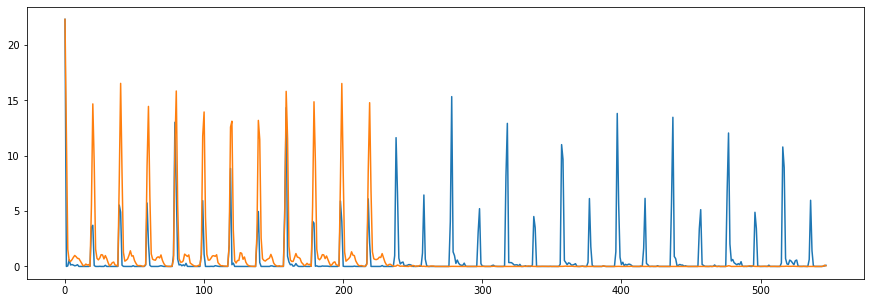

In [132]:
plt.plot(src[0, :])
plt.plot(dst[0, :]);

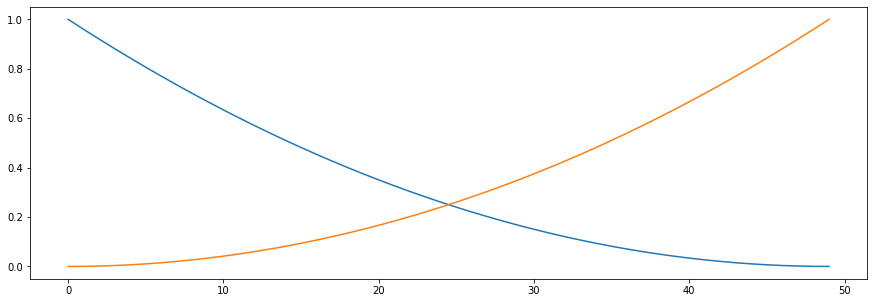

In [42]:
t = np.linspace(0, 1, 50)
src_t = np.power(1-t, 2)
dst_t = np.power(t, 2)

plt.plot(src_t)
plt.plot(dst_t)
plt.show()

#### Activation resynthesis 

In [267]:
act = src[2, :200]
act /= act.max()
peaks, peaks_info = find_peaks(np.insert(act, 0, 0), distance=2, prominence=0.05)
peaks -= 1

In [268]:
from findpeaks import findpeaks

In [291]:
fp = findpeaks(lookahead=3, method='topology', verbose=0)

In [292]:
data = fp.fit(np.insert(act, 0, 0))

In [271]:
data['df']['labx'] = data['df']['labx'].astype(int)

In [272]:
groups = data['df'].groupby("labx")

In [273]:
data['df']

,x,y,labx,rank,score,valley,peak
0,0,0.000000e+00,1,0,0.000000,True,False
1,1,3.856997e-01,1,19,0.385699,False,True
2,2,1.675981e-04,1,0,0.000000,False,False
3,3,3.942016e-07,2,0,0.000000,True,False
4,4,2.272524e-05,2,0,0.000000,False,False
...,...,...,...,...,...,...,...
196,196,7.452307e-03,43,0,0.000000,True,False
197,197,6.105538e-02,43,0,0.000000,False,False
198,198,4.709568e-01,43,14,0.470957,False,True
199,199,3.989221e-01,43,0,0.000000,False,False


In [274]:
peak_heights = groups['y'].max()
peak_score = groups['score'].max()
peak_idxs = groups.indices

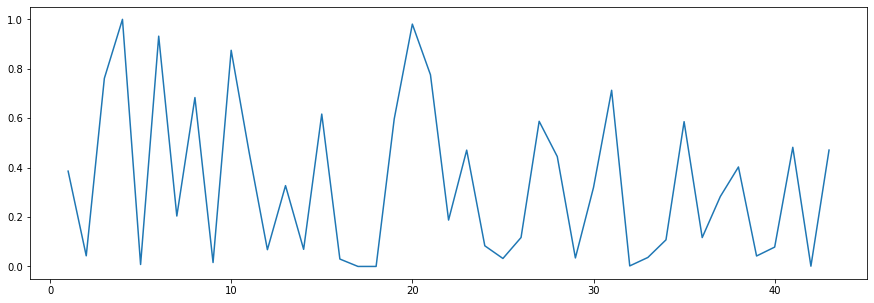

In [276]:
plt.plot(peak_score)

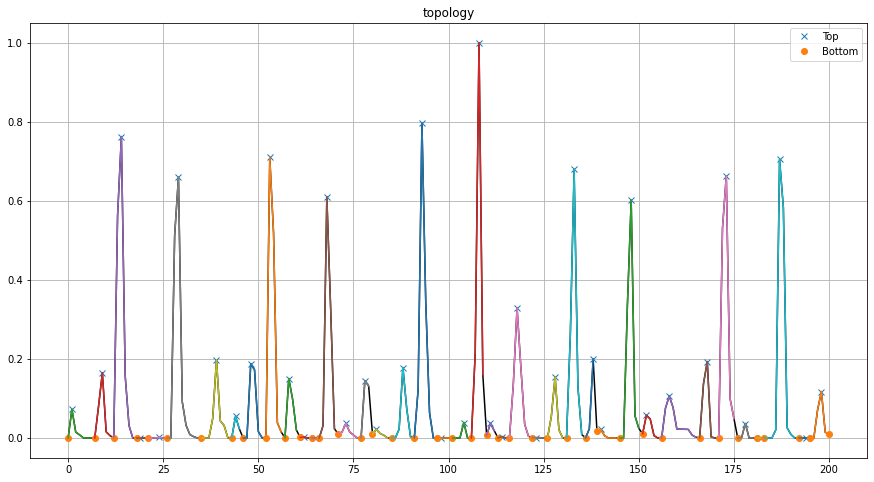

(None, <AxesSubplot:title={'center':'topology'}>)

In [266]:
fp.plot()

In [286]:
act_r = np.zeros_like(act)

t = 0.8

for i in peak_idxs.keys():
    if peak_score[i] < 0.2:
        continue
    
    if peak_heights[i] < t:
        continue
        
    act_r[peak_idxs[i]-1] = act[peak_idxs[i]-1]

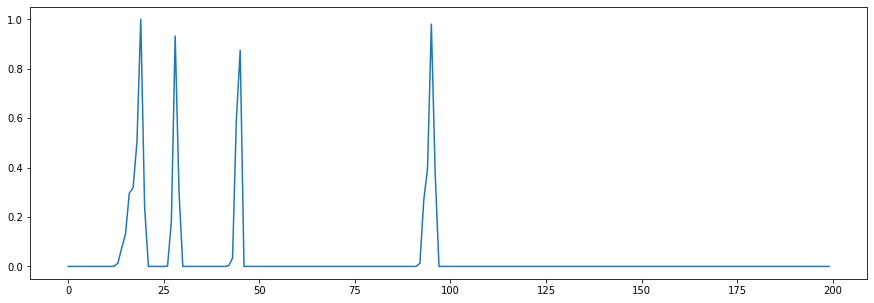

In [287]:
plt.plot(act_r)

In [217]:
peaks_info

{'prominences': array([0.38569935, 0.76129466, 1.        , 0.93198478, 0.20403954,
        0.68342427, 0.87478602, 0.45833864, 0.0678612 , 0.3270533 ,
        0.06930762, 0.61663711, 0.59706725, 0.98071617, 0.77575731,
        0.18775009, 0.47074383, 0.0835488 , 0.11703373, 0.58740246,
        0.44472969, 0.31961186, 0.71300206, 0.10765254, 0.58594115,
        0.1168142 , 0.28306951, 0.40258202, 0.0783477 , 0.48217493,
        0.26291001]),
 'left_bases': array([  0,   0,   0,  24,  31,  37,  37,  47,  53,  53,  61,  65,  82,
         65,  98, 103, 103, 114, 117, 103, 132, 137, 146, 154, 154, 170,
        172, 172, 183, 186, 194]),
 'right_bases': array([  3,  13, 146,  65,  37,  43,  65,  65,  58,  65,  65,  82,  93,
        146, 146, 107, 127, 117, 127, 146, 146, 146, 154, 167, 194, 172,
        177, 186, 186, 194, 200])}

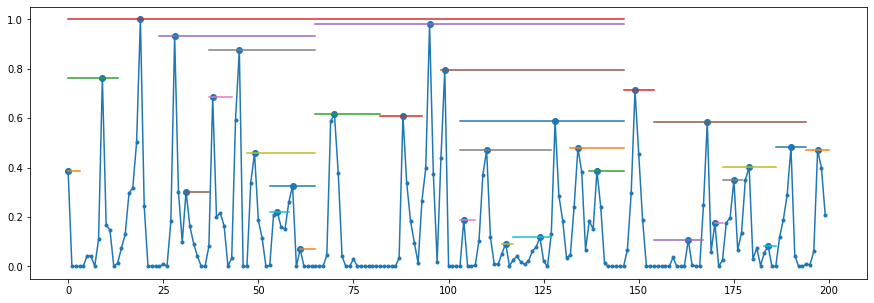

In [218]:
plt.plot(act, marker='.')
plt.scatter(peaks, act[peaks])
for i in range(len(peaks_info['left_bases'])):
    left = peaks_info['left_bases'][i]
    right = peaks_info['right_bases'][i]
#     plt.axvspan(left, right, alpha=0.3)
    plt.plot([left, right], [act[peaks[i]]]*2,)

In [68]:
def makePeak(height):
    atk = np.power(np.linspace(0, 1, 3), 6) * height
    dec = np.power(np.linspace(1, 0, 4), 6) * height
    
    peak = np.concatenate([atk, dec[1:]])
    return peak, len(atk) - 1

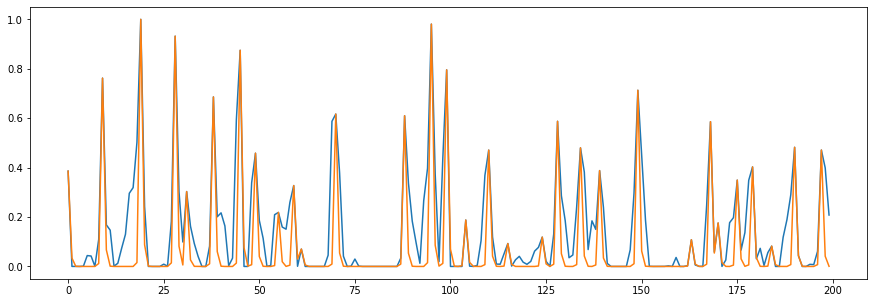

In [70]:
act_h = np.zeros_like(act)

for p in peaks:
    h = act[p]
    peak_h, idx_offset = makePeak(h)
    
    start = p - idx_offset
    if start < 0:
        peak_h = peak_h[-start:]
        start = 0
        
    length = min(len(peak_h), len(act_h) - start)    
    end = start + length
    
    act_h[start:end] += peak_h[:length]
    
plt.plot(act)
plt.plot(act_h)
plt.show()

In [152]:
class SmoothTransition:
    def __init__(self, src, trg):
        assert src.shape == trg.shape
        
        self.src = src / src.max()
        self.trg = trg / trg.max()
        
        self.src_peaks, _ = find_peaks(np.insert(self.src, 0, 0), distance=2, prominence=0.01)
        self.trg_peaks, _ = find_peaks(np.insert(self.trg, 0, 0), distance=2, prominence=0.01)
        
        self.src_peaks -= 1
        self.trg_peaks -= 1
    
    def transform(self, t):
        t = min(max(t, 0.0), 1.0)

        peaks_src = self.src_peaks[np.where(self.src[self.src_peaks] >= t)]
        peaks_trg = self.trg_peaks[np.where(self.trg[self.trg_peaks] <= t)]
        
        act_t = np.zeros_like(self.src)
        
        for ps in peaks_src:
            act_t = self.add_peak(act_t, ps, self.src[ps])
            
        for pt in peaks_trg:
            act_t = self.add_peak(act_t, pt, self.trg[pt])
            
        return act_t
    
    __call__ = transform
            
    @staticmethod
    def add_peak(a, p, h):
        peak_h, idx_offset = SmoothTransition.makePeak(h)

        start = p - idx_offset
        if start < 0:
            peak_h = peak_h[-start:]
            start = 0

        length = min(len(peak_h), len(a) - start)    
        end = start + length

        a[start:end] += peak_h[:length]
        return a
    
    @staticmethod
    def makePeak(height):
        atk = np.power(np.linspace(0, 1, 3), 6) * height
        dec = np.power(np.linspace(1, 0, 4), 6) * height

        peak = np.concatenate([atk, dec[1:]])
        return peak, len(atk) - 1

In [153]:
sm = SmoothTransition(src[0], dst[0])

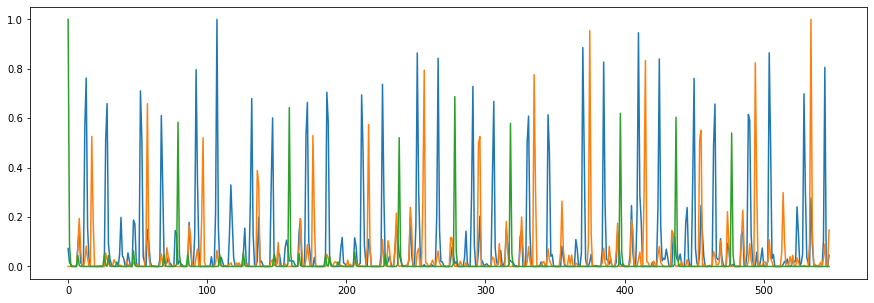

In [154]:
act_h = sm(0.5)
plt.plot(src[1]/src[1].max())
plt.plot(dst[1]/dst[1].max())
plt.plot(act_h);

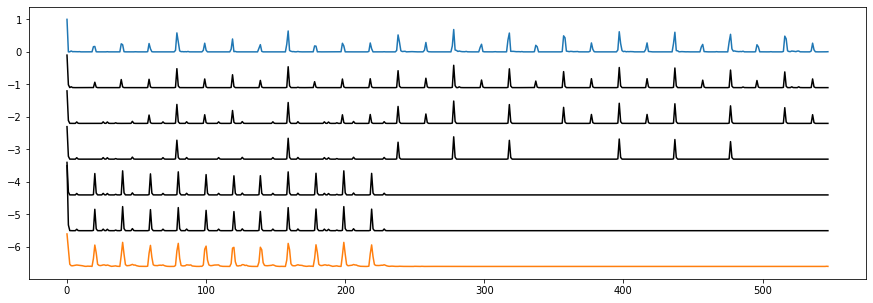

In [155]:
plt.plot(sm.src)

offset = 1
for t in np.linspace(0, 1, 5):
    a = sm(t)
    plt.plot(a - offset*1.1, c='k')
    offset += 1
    
plt.plot(sm.trg - offset*1.1)
plt.show()

### Wasserstein Transformation 

In [7]:
k = 300

ps, qs = src[0][:k], dst[0][:k]
ps, qs = ps/ps.sum(), qs/qs.sum()

In [12]:
sm = SmoothTransform(steps=5)

In [13]:
trans = sm.transform(ps, qs)

  0%|          | 0/5 [00:00<?, ?it/s]

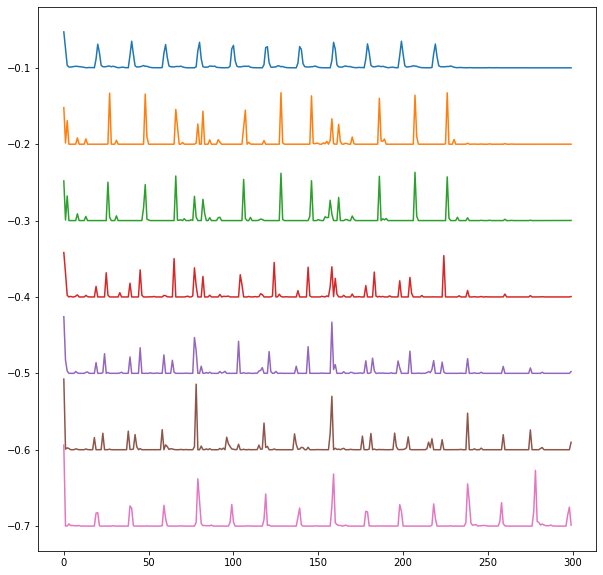

In [14]:
sm.plot_transform(trans, source=ps, target=qs)

In [15]:
trans.shape

(5, 300)

### Custom Mehtod 

In [63]:
v0 = np.zeros(12)
v0[1] = 0.5
v0[6] = 0.5

v1 = np.zeros(12)
v1[3] = 0.5
v1[9] = 0.5

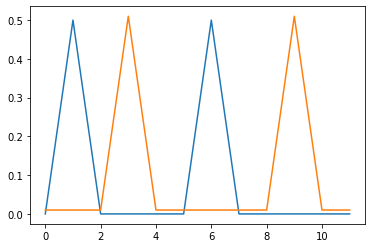

In [65]:
plt.plot(v0)
plt.plot(v1+0.01);

In [83]:
T = np.zeros((12, 12))
T[1, 3] = 0.5
T[6, 9] = 0.5

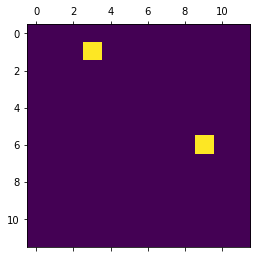

In [84]:
plt.matshow(T);

In [85]:
def interp(v0, v1, T, p):
    vp = np.zeros_like(v0)
    for i in range(len(vp)):
        js = np.where(T[i] > 0)[0]
        for j in js:
            j_p = int(p * j + (1-p)*i)
            vp[j_p] += T[i, j]
            
    return vp

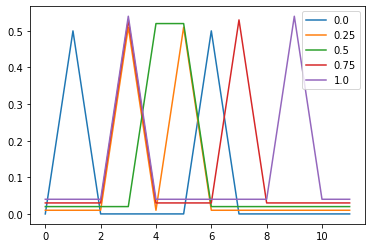

In [82]:
for i, p in enumerate(np.linspace(0, 1, 5)):
    plt.plot(interp(v0, v1, T, p)+0.01*i, label=p)
    
plt.legend()
plt.show()